In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display

from MatCSCM import MatCSCM, keyword_to_text, plot_elastic_compression_curve
from CEB import *
from plotcurves import *

# CSCM Material Keyword Generator

This interactive tool generates CSCM material keywords for LS-DYNA based on specified concrete parameters.

In [2]:
# Note: plot_elastic_compression_curve function has been moved to MatCSCM.py
# and is now imported at the top of the notebook

# Initial plot with default f_c value can be uncommented if needed
# plot_elastic_compression_curve(33.0)

In [3]:
# Create interactive widgets for parameter input
f_c_widget = widgets.FloatText(
    value=33.0,
    description='f_c (MPa):',
    disabled=False,
    style={'description_width': 'initial'}
)

d_max_widget = widgets.FloatText(
    value=18.0,
    description='d_max (mm):',
    disabled=False,
    style={'description_width': 'initial'}
)

rho_widget = widgets.FloatText(
    value=2.4E-09,
    description='rho:',
    disabled=False,
    style={'description_width': 'initial'}
)

nplot_widget = widgets.Dropdown(
    options=[
        ('1: Maximum of brittle and ductile damage (default)', 1),
        ('2: Maximum of brittle and ductile damage, with recovery of brittle damage', 2),
        ('3: Brittle damage', 3),
        ('4: Ductile damage', 4),
        ('5: κ (intersection of cap with shear surface)', 5),
        ('6: X₀ (intersection of cap with pressure axis)', 6),
        ('7: εᵥᵖ (plastic volume strain)', 7)
    ],
    value=1,
    description='NPLOT:',
    disabled=False,
    style={'description_width': 'initial'}
)

iretrc_widget = widgets.Dropdown(
    options=[
        ('0: Cap does not retract (default)', 0),
        ('1: Cap retracts', 1)
    ],
    value=0,
    description='IRETRC:',
    disabled=False,
    style={'description_width': 'initial'}
)

output_widget = widgets.Output()
curve_output_widget = widgets.Output()

def update_output(*args):
    with output_widget:
        output_widget.clear_output()
        
        f_c = f_c_widget.value
        d_max = d_max_widget.value
        rho = rho_widget.value
        nplot = nplot_widget.value
        iretrc = iretrc_widget.value
        
        mat_cscm = MatCSCM(
            f_c=f_c,
            dmax=d_max,
            rho=rho,
            nplot=nplot,
            itretrc=iretrc,
            irate='on',
            erode='off',
            pred='off',
            recov='full'
        )
        
        keyword_data = mat_cscm.generate_keyword()
        result = keyword_to_text(keyword_data) + mat_cscm.get_ceb_output()
        print(result)

# Bind update function to widget changes
f_c_widget.observe(update_output, names='value')

def update_elastic_curve(*args):
    with curve_output_widget:
        curve_output_widget.clear_output()
        f_c = f_c_widget.value
        plot_elastic_compression_curve(f_c)

f_c_widget.observe(update_elastic_curve, names='value')
d_max_widget.observe(update_output, names='value')
rho_widget.observe(update_output, names='value')
nplot_widget.observe(update_output, names='value')
iretrc_widget.observe(update_output, names='value')

# Display widgets
display(widgets.VBox([
    widgets.HTML('<h3>Material Parameters</h3>'),
    f_c_widget,
    d_max_widget,
    rho_widget,
    nplot_widget,
    iretrc_widget,
    widgets.HTML('<h3>Elastic Compression Curve</h3>'),
    curve_output_widget,
    widgets.HTML('<h3>Result</h3>'),
    output_widget
]))

# Initialize output
update_output()
update_elastic_curve()

# CSCM Compression Curve Visualization

This section demonstrates the stress-strain behavior of concrete under uniaxial compression using the CSCM model.

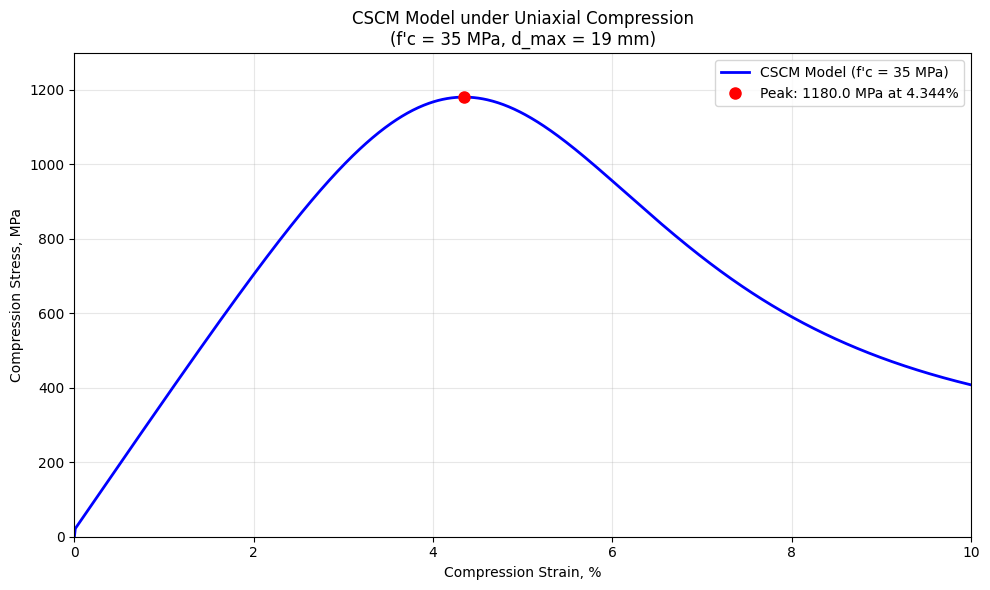

In [6]:
# Import the compression visualization function
from MatCSCM import plot_cscm_compression

# Create CSCM model with default parameters
cscm_model = MatCSCM(f_c=35, dmax=19)

# Plot compression curve
plot_cscm_compression(cscm_model, max_strain=0.1, num_points=1000)
plt.show()

In [5]:
# Interactive visualization with parameter control
f_c_plot_widget = widgets.FloatSlider(
    value=35.0,
    min=20.0,
    max=60.0,
    step=5.0,
    description='f_c (MPa):',
    style={'description_width': 'initial'}
)

dmax_plot_widget = widgets.FloatSlider(
    value=19.0,
    min=10.0,
    max=30.0,
    step=1.0,
    description='d_max (mm):',
    style={'description_width': 'initial'}
)

max_strain_widget = widgets.FloatSlider(
    value=0.008,
    min=0.002,
    max=0.015,
    step=0.001,
    description='Max strain:',
    style={'description_width': 'initial'}
)

compression_output_widget = widgets.Output()

def update_compression_plot(*args):
    with compression_output_widget:
        compression_output_widget.clear_output()
        
        f_c = f_c_plot_widget.value
        dmax = dmax_plot_widget.value
        max_strain = max_strain_widget.value
        
        # Create CSCM model with current parameters
        cscm_model = MatCSCM(f_c=f_c, dmax=dmax)
        
        # Plot compression curve
        plot_cscm_compression(cscm_model, max_strain=max_strain, num_points=1000)
        plt.show()

# Bind update function to widget changes
f_c_plot_widget.observe(update_compression_plot, names='value')
dmax_plot_widget.observe(update_compression_plot, names='value')
max_strain_widget.observe(update_compression_plot, names='value')

# Display interactive widgets
display(widgets.VBox([
    widgets.HTML('<h3>Interactive CSCM Compression Curve</h3>'),
    f_c_plot_widget,
    dmax_plot_widget,
    max_strain_widget,
    compression_output_widget
]))

# Initialize plot
update_compression_plot()